In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import sparse
from bs4 import BeautifulSoup
from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

from keras import utils
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Layer, Input, GlobalMaxPooling1D, UpSampling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Reshape, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Concatenate, Bidirectional
from tensorflow.keras.models import Model

import time

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Классификация текста по полу автора дневниковых записей**

## **Разведочный анализ данных**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_preprocessing_final.csv')

<ipython-input-4-68012c472933>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_preprocessing_final.csv')


In [5]:
del data['Unnamed: 0']
data.head(5)

,id,diary,text,date,sex,birth,age,text_preprocessing
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42.0,социализм завод храм центр человеческий житие ...
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...


In [6]:
# Заменяем значения 0.0 и 1.0 на 0 и 1 соответственно
data['sex'] = data['sex'].astype(int)

In [7]:
sex_counts = data['sex'].value_counts()

print("Количество значений 0 в столбце 'sex':", sex_counts.get(0, 0))
print("Количество значений 1 в столбце 'sex':", sex_counts.get(1, 0))

Количество значений 0 в столбце 'sex': 75578
Количество значений 1 в столбце 'sex': 361652


In [8]:
data_plot = data.copy()

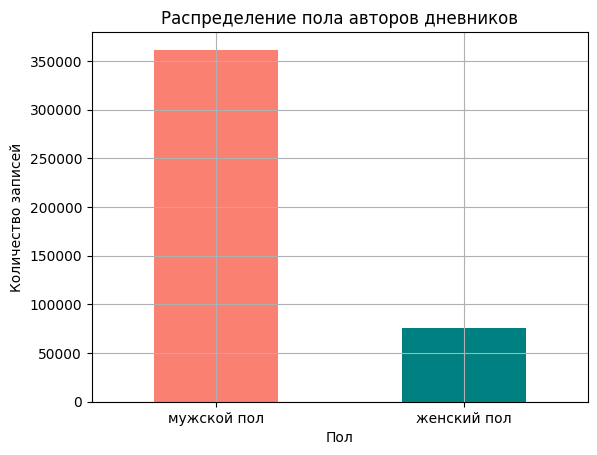

In [9]:
# Замена значений на 'мужской пол' и 'женский пол'
data_plot['sex'] = data_plot['sex'].replace({1: 'мужской пол', 0: 'женский пол'})

# Построение гистограммы
data_plot['sex'].value_counts().plot(kind='bar', color=['salmon', 'teal'])
plt.xlabel('Пол')
plt.ylabel('Количество записей')
plt.title('Распределение пола авторов дневников')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

## **Подготовка текстов**

In [ ]:
data['text_preprocessing'] = data['text_preprocessing'].fillna('')

In [ ]:
# Токенизация текста
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text_preprocessing'])
word_index = tokenizer.word_index

In [ ]:
# Конвертация текстов в последовательности
sequences = tokenizer.texts_to_sequences(data['text_preprocessing'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# Подготовка целевой переменной
labels = pd.get_dummies(data['sex']).values

In [ ]:
# Разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

## **Эксперименты по определению пола автора с помощью классических алгоритмов МО**

### **№1: LogitRegression**

In [10]:
# Разделение на признаки и целевую переменную
X = data['text_preprocessing']
y = data['sex']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Заменяем все значения NaN пустой строкой
X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test_vec)

# Оценка модели
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.83      0.49      0.62     15116
           1       0.90      0.98      0.94     72330

    accuracy                           0.89     87446
   macro avg       0.87      0.73      0.78     87446
weighted avg       0.89      0.89      0.88     87446



In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.8947007295931203


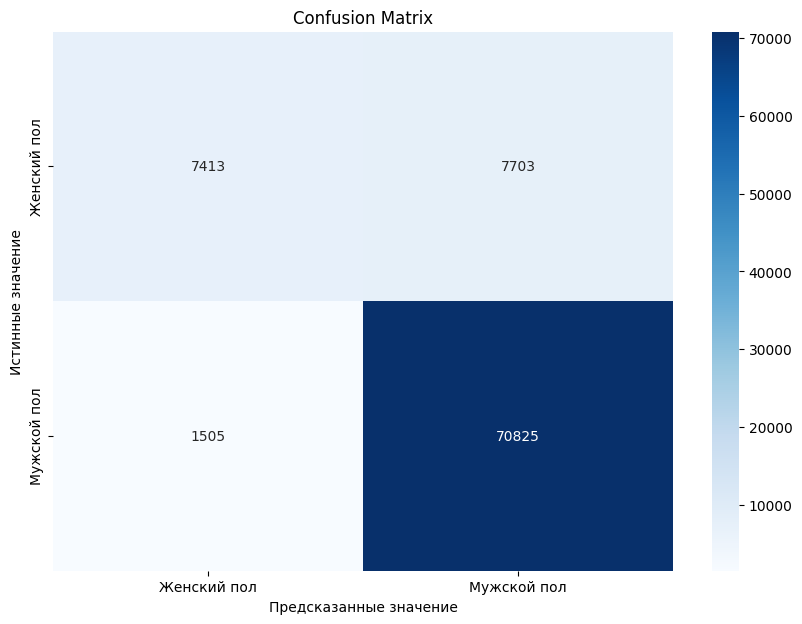

In [13]:
# Вычисление матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=['Женский пол', 'Мужской пол'], yticklabels=['Женский пол', 'Мужской пол'])
plt.xlabel('Предсказанные значение')
plt.ylabel('Истинные значение')
plt.title('Confusion Matrix')
plt.show()

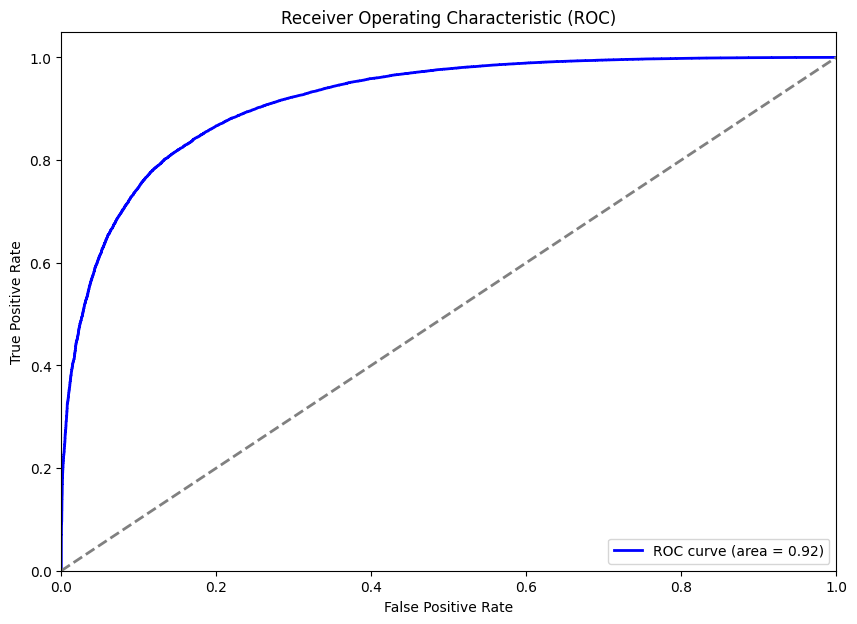

In [ ]:
# Предсказания вероятностей класса для ROC-кривой
y_prob = model.predict_proba(X_test_vec)[:, 1]

# Вычисление метрик для ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob)

# Визуализация ROC-кривой
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Получение важных слов
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()

# Создание DataFrame с результатами
importance_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='coefficient', ascending=False)

# Вывод самых важных слов
print("Слова, которые больше всего повлияли на принятие решений модели:")
print(importance_df.head(50))

Слова, которые больше всего повлияли на принятие решений модели:
                 word  coefficient
140808           ирка     6.699755
6629            аликс     6.000219
130359         зинуля     5.909906
442659           юрка     5.776410
205144         митька     5.137111
436775             що     5.112070
169764        кратово     4.705241
100631           дора     4.687628
442528             юр     4.639160
208269         монета     4.555196
112884           жена     4.508479
134484            ибо     4.423943
436512          щерба     4.369360
108658         ельник     4.337234
207195           моип     4.318124
382754           теща     4.185934
142891            ица     4.059166
90022             деж     4.053983
100770          дорка     3.994949
313731         пташка     3.990503
357421     смоленское     3.984119
239465           ныне     3.954917
163636  консерватория     3.928261
188295        львовна     3.912698
205034         митрий     3.835632
109756             ер    

### **№2: Multinominal Naive Bayes**

In [14]:
# Предобработка текста (предполагается, что текст уже предобработан и находится в столбце 'text_preprocessing')
X = data['text_preprocessing']
y = data['sex']

X.fillna('', inplace=True)

# Преобразование текста в матрицу признаков
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Инициализация и обучение модели наивного Байеса
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = nb_model.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')
print(classification_report(y_test, y_pred))

Точность модели: 0.8334858083846031
              precision    recall  f1-score   support

           0       0.51      0.70      0.59     15116
           1       0.93      0.86      0.90     72330

    accuracy                           0.83     87446
   macro avg       0.72      0.78      0.74     87446
weighted avg       0.86      0.83      0.84     87446



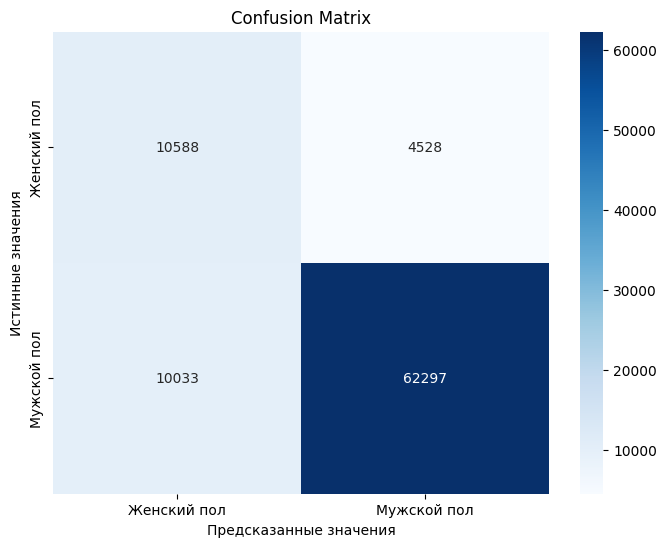

In [16]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Отображение матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Женский пол', 'Мужской пол'], yticklabels=['Женский пол', 'Мужской пол'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

## **Эксперименты по определению пола автора с помощью нейросетей**

### **№1: CNN1D**

In [ ]:
model_1 = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/35
5466/5466 [==============================] - 361s 66ms/step - loss: 0.3715 - accuracy: 0.8469 - val_loss: 0.3321 - val_accuracy: 0.8601
Epoch 2/35
5466/5466 [==============================] - 338s 62ms/step - loss: 0.3248 - accuracy: 0.8635 - val_loss: 0.3203 - val_accuracy: 0.8650
Epoch 3/35
5466/5466 [==============================] - 334s 61ms/step - loss: 0.2971 - accuracy: 0.8752 - val_loss: 0.3140 - val_accuracy: 0.8690
Epoch 4/35
5466/5466 [==============================] - 330s 60ms/step - loss: 0.2695 - accuracy: 0.8862 - val_loss: 0.3220 - val_accuracy: 0.8698
Epoch 5/35
5466/5466 [==============================] - 326s 60ms/step - loss: 0.2404 - accuracy: 0.8985 - val_loss: 0.3452 - val_accuracy: 0.8686
Epoch 6/35
5466/5466 [==============================] - 323s 59ms/step - loss: 0.2105 - accuracy: 0.9110 - val_loss: 0.3475 - val_accuracy: 0.8648
Epoch 7/35
5466/5466 [==============================] - 324s 59ms/step - loss: 0.1824 - accuracy: 0.9231 - val_loss: 0

In [ ]:
val_loss, val_accuracy = model_1.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

2733/2733 [==============================] - 23s 8ms/step - loss: 1.3024 - accuracy: 0.8357
Функционал ошибки: 1.302428960800171 
Точность модели: 0.8356928825378418


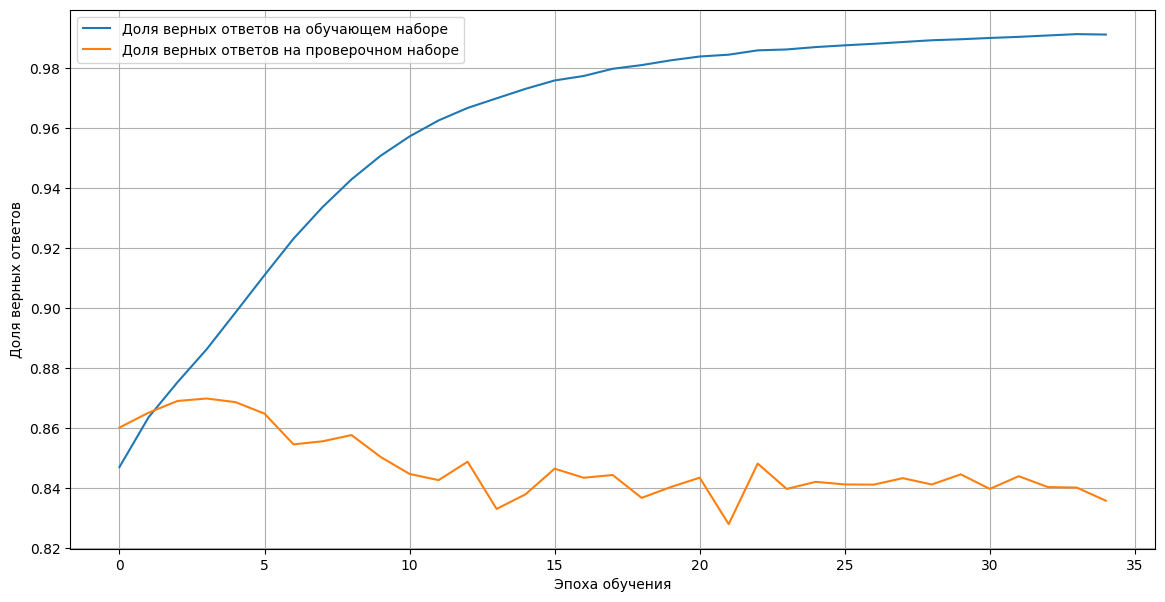

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_1.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_1.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

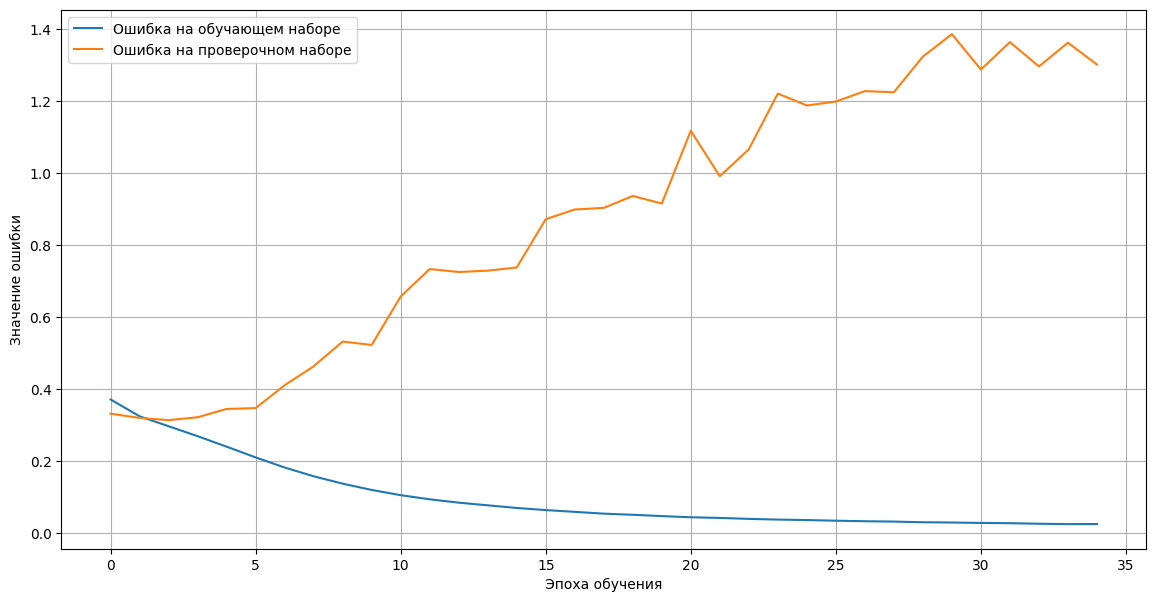

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_1.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_1.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Сохранение модели
model_1.save('model_gender_CNN1D.h5')

### **№2: LSTM**

In [ ]:
model_2 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Увеличим размерность Embedding
    SpatialDropout1D(0.4),  # Увеличим коэффициент Dropout

    Conv1D(256, 3, activation='relu'),  # Увеличим количество фильтров и уменьшим размер ядра
    GlobalMaxPooling1D(),
    Dropout(0.4),

    Reshape((1, -1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(2, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
10931/10931 [==============================] - 755s 69ms/step - loss: 0.3093 - accuracy: 0.8701 - val_loss: 0.3240 - val_accuracy: 0.8663
Epoch 2/10
10931/10931 [==============================] - 745s 68ms/step - loss: 0.3050 - accuracy: 0.8724 - val_loss: 0.3252 - val_accuracy: 0.8671
Epoch 3/10
10931/10931 [==============================] - 749s 69ms/step - loss: 0.3021 - accuracy: 0.8733 - val_loss: 0.3265 - val_accuracy: 0.8684
Epoch 4/10
10931/10931 [==============================] - 756s 69ms/step - loss: 0.2976 - accuracy: 0.8758 - val_loss: 0.3187 - val_accuracy: 0.8685
Epoch 5/10
10931/10931 [==============================] - 749s 69ms/step - loss: 0.2948 - accuracy: 0.8776 - val_loss: 0.3212 - val_accuracy: 0.8674
Epoch 6/10
10931/10931 [==============================] - 758s 69ms/step - loss: 0.2915 - accuracy: 0.8781 - val_loss: 0.3265 - val_accuracy: 0.8685
Epoch 7/10
10931/10931 [==============================] - 755s 69ms/step - loss: 0.2886 - accuracy: 0.8794

In [ ]:
val_loss, val_accuracy = model_2.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

2733/2733 [==============================] - 53s 19ms/step - loss: 0.3237 - accuracy: 0.8676
Функционал ошибки: 0.32369935512542725 
Точность модели: 0.8676440119743347


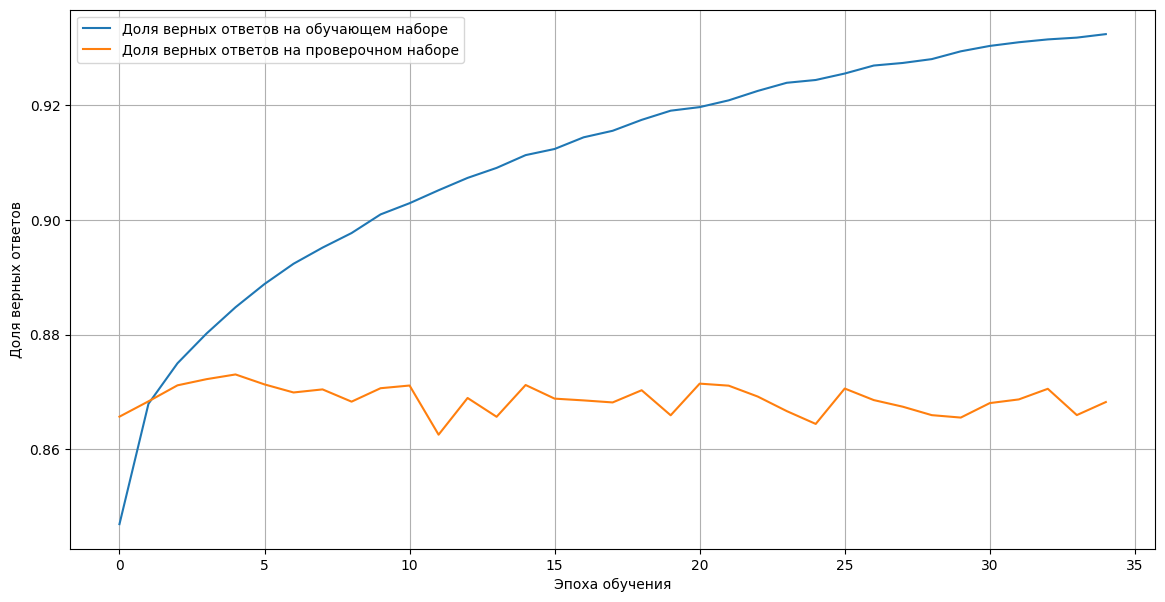

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_2.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_2.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

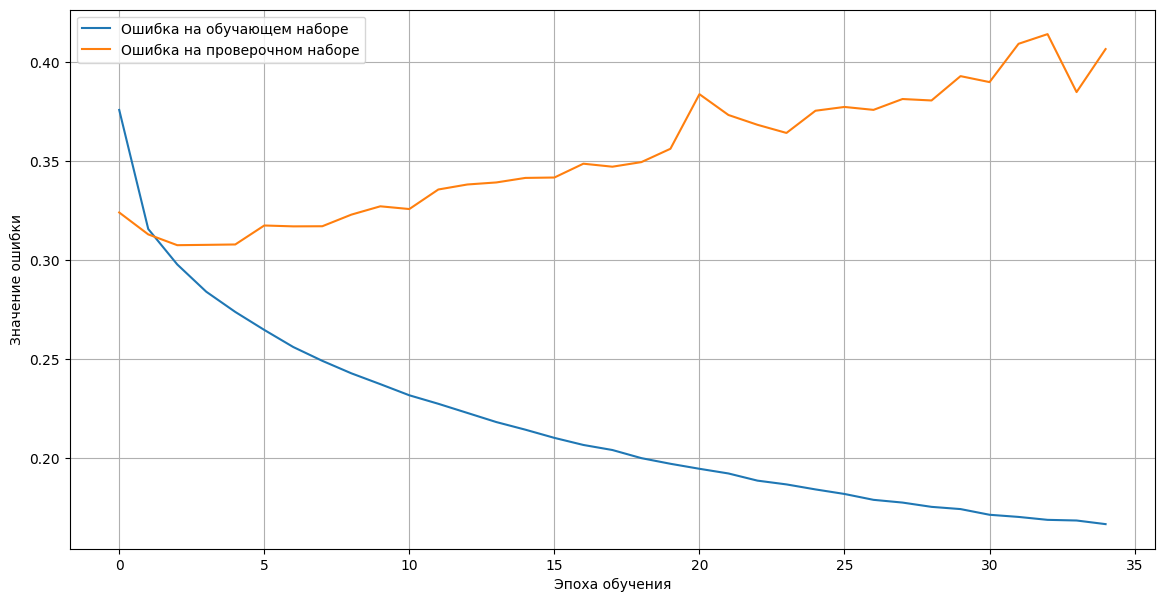

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_2.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_2.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_2.save('model_gender_LSTM.h5')

###**№3: BiLSTM**

In [ ]:
model_3 = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    SpatialDropout1D(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),  # Добавлен возврат последовательностей для следующего LSTM слоя
    BatchNormalization(),
    LSTM(64),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [ ]:
# Настройка оптимизатора с заданной скоростью обучения
optimizer = Adam(learning_rate=0.001)

model_3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/35
5466/5466 [==============================] - 198s 35ms/step - loss: 0.3593 - accuracy: 0.8509 - val_loss: 0.3270 - val_accuracy: 0.8572
Epoch 2/35
5466/5466 [==============================] - 118s 22ms/step - loss: 0.3100 - accuracy: 0.8704 - val_loss: 0.3045 - val_accuracy: 0.8732
Epoch 3/35
5466/5466 [==============================] - 115s 21ms/step - loss: 0.2930 - accuracy: 0.8778 - val_loss: 0.3072 - val_accuracy: 0.8719
Epoch 4/35
5466/5466 [==============================] - 113s 21ms/step - loss: 0.2807 - accuracy: 0.8823 - val_loss: 0.3008 - val_accuracy: 0.8760
Epoch 5/35
5466/5466 [==============================] - 120s 22ms/step - loss: 0.2701 - accuracy: 0.8868 - val_loss: 0.3083 - val_accuracy: 0.8726
Epoch 6/35
5466/5466 [==============================] - 118s 22ms/step - loss: 0.2617 - accuracy: 0.8906 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 7/35
5466/5466 [==============================] - 118s 22ms/step - loss: 0.2539 - accuracy: 0.8944 - val_loss: 0

In [ ]:
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Точность модели: {accuracy:.2%}')

2733/2733 [==============================] - 32s 12ms/step - loss: 0.3891 - accuracy: 0.8657
Точность модели: 86.57%


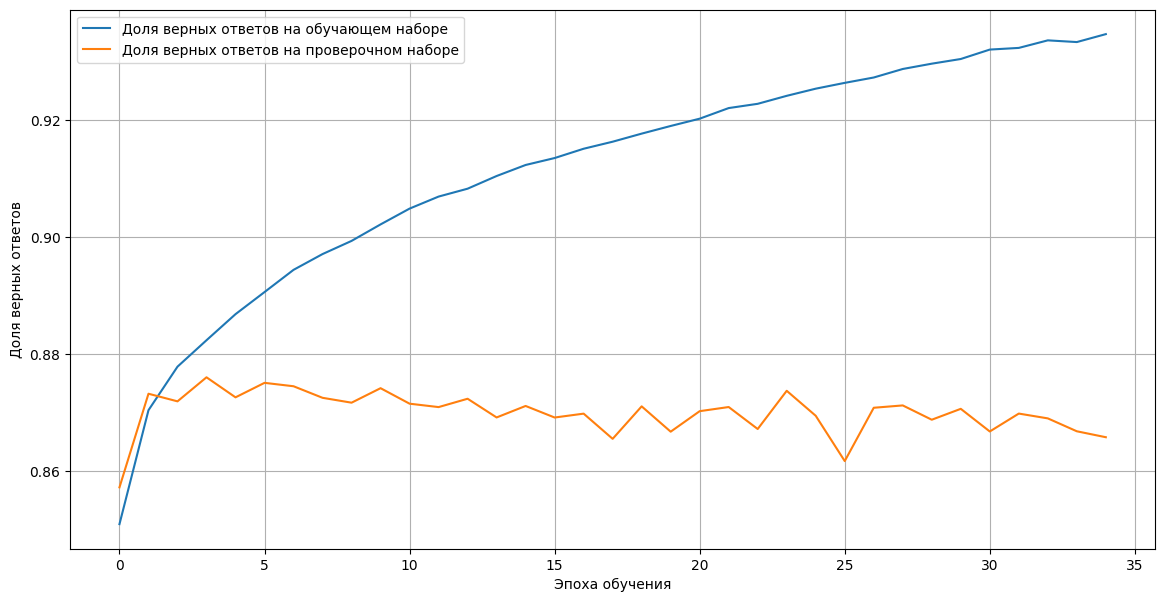

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_3.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_3.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

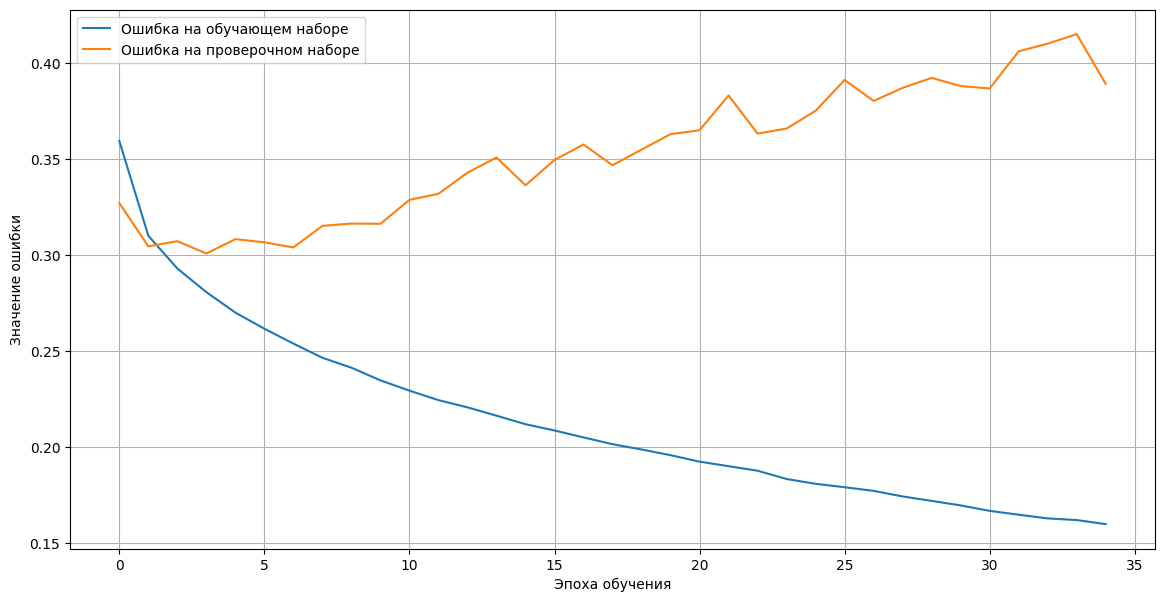

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_3.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_3.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_3.save('model_gender_BiLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Эксперимент с сохранением глаголов прошедшего времени**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_final_with_past_verbs.csv')

NameError: name 'pd' is not defined

In [ ]:
data.head()

,id,diary,text,date,sex,birth,age,text_preprocessing,text_preprocessing_past_verbs
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...,бить башенный часы полночь жена спать ребенок ...
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...,читать шаляпин воспоминание оказываться истори...
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1,1890-05-25,42.0,социализм завод храм центр человеческий житие ...,социализм завод храм центр человеческий житие ...
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...,завтра утро москва ждать каково настроение шир...
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...,берлин полпредство оказываться горький проезд ...


In [ ]:
data['text']

0         Сейчас бьет на башенных часах 12. Полночь. Жен...
1         Читал Шаляпина — воспоминания. Оказывается, ис...
2         При социализме заводы суть храмы и центры чело...
3         Завтра с утра — в Москву. Что-то меня там ждет...
4         В Берлине, в полпредстве, оказался Горький (пр...
                                ...                        
437225    21 сентября (понедельник), 1970 год\nКак мне х...
437226    22 сентября (вторник), 1970 годПисать сегодня ...
437227    23 сентября (среда), 1970 год\nНу вот прошел и...
437228    24 сентября (четверг), 1970 годМы были вместе ...
437229    25 сентября (пятница), 1970 год\nЭто, наверно,...
Name: text, Length: 437230, dtype: object

In [ ]:
data['text'][10]

'У Литвинова. Он убеждает, что мне надо уезжать из Праги. На основании глупейшего доноса Полоцкого. Крестинский написал (конечно, как и все, что он делает по неразвитости и глупости пополам с хитростью) содонос в ЦК, а Литвинов как нарком сделал выводы не в пользу меня, конечно. Один Карахан по-прежнему хорошо расположен ко мне, на доносе Крестинского он написал: «Аросева убрать из Праги не возражаю, но ему следует предоставить работу в другом полпредстве». Мы говорили с ним о Турции, Тегеране и даже Японии.\nЛитвинов убеждал меня, что в ГПУ имеется материал против меня. Я возражал — какой же там может быть материал, кроме искусных выдумок карьеристов. Литвинов сказал: «С моей точки зрения тоже это не материал, но они его считают материалом». Я отвечал: «Меня ЦК и Политбюро достаточно знают, чтобы выдумки и злопыхательства моих неприятелей могли повлиять на их решение». Литвинов спрашивал, почему же сотрудники жалуются только на меня. Я опять возразил: «Неверно, не только на меня» — «Н

In [ ]:
data['text_preprocessing_past_verbs'][10]

'литвинова убеждать уезжать прага основание глупый донос полоцкий крестинский написать делать неразвитость глупость пополам хитрость содонос цк литвинов нарком сделать вывод польза карахать прежний располагать ко донос крестинский написать аросев убирать прага возражать следовать предоставлять работа полпредство говорить турция тегеран япония литвинов убеждать гпу иметься материал против возражать мочь материал кроме искусный выдумка карьерист литвинов сказать точка зрение это материал считать материал отвечать цк политбюро достаточно знать выдумка злопыхательство неприятель мочь повлиять решение литвинов спрашивать почему сотрудник жаловаться возражать неверно антонов овсеенко жена замечать максим максимович который жаловаться процесс иной борьба против старый партиец истинный революционер это говорить год назад францисбад это соглашаться полноте отмахиваться литвинов свой прежний согласие  написал сделал говорили убеждал возражал могли заметил говорил отмахнулся'

## **Эксперимент по обучения модели с учетом знания о глаголах в прошедшем времени**

In [ ]:
data['text_preprocessing_past_verbs'] = data['text_preprocessing_past_verbs'].astype(str)

In [ ]:
# Токенизация текста
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text_preprocessing_past_verbs'])
word_index = tokenizer.word_index

In [ ]:
# Конвертация текстов в последовательности
sequences = tokenizer.texts_to_sequences(data['text_preprocessing_past_verbs'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# Подготовка целевой переменной
labels = pd.get_dummies(data['sex']).values

In [ ]:
# Разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

### **LSTM**

In [ ]:
model_4 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Увеличим размерность Embedding
    SpatialDropout1D(0.4),  # Увеличим коэффициент Dropout

    Conv1D(256, 3, activation='relu'),  # Увеличим количество фильтров и уменьшим размер ядра
    GlobalMaxPooling1D(),
    Dropout(0.4),

    Reshape((1, -1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(2, activation='softmax')
])

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Настройка параметров Early Stopping
# monitor: метрика для мониторинга
# patience: сколько эпох ждать после последнего лучшего результата
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_4 = model_4.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/35
10931/10931 [==============================] - 161s 14ms/step - loss: 0.3277 - accuracy: 0.8663 - val_loss: 0.2980 - val_accuracy: 0.8766
Epoch 2/35
10931/10931 [==============================] - 117s 11ms/step - loss: 0.2999 - accuracy: 0.8770 - val_loss: 0.2923 - val_accuracy: 0.8802
Epoch 3/35
10931/10931 [==============================] - 118s 11ms/step - loss: 0.2896 - accuracy: 0.8807 - val_loss: 0.2902 - val_accuracy: 0.8795
Epoch 4/35
10931/10931 [==============================] - 119s 11ms/step - loss: 0.2827 - accuracy: 0.8844 - val_loss: 0.2864 - val_accuracy: 0.8817
Epoch 5/35
10931/10931 [==============================] - 116s 11ms/step - loss: 0.2774 - accuracy: 0.8865 - val_loss: 0.2856 - val_accuracy: 0.8819
Epoch 6/35
10931/10931 [==============================] - 129s 12ms/step - loss: 0.2730 - accuracy: 0.8878 - val_loss: 0.2876 - val_accuracy: 0.8831
Epoch 7/35
10931/10931 [==============================] - 143s 13ms/step - loss: 0.2694 - accuracy: 0.8896

In [ ]:
val_loss, val_accuracy = model_4.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

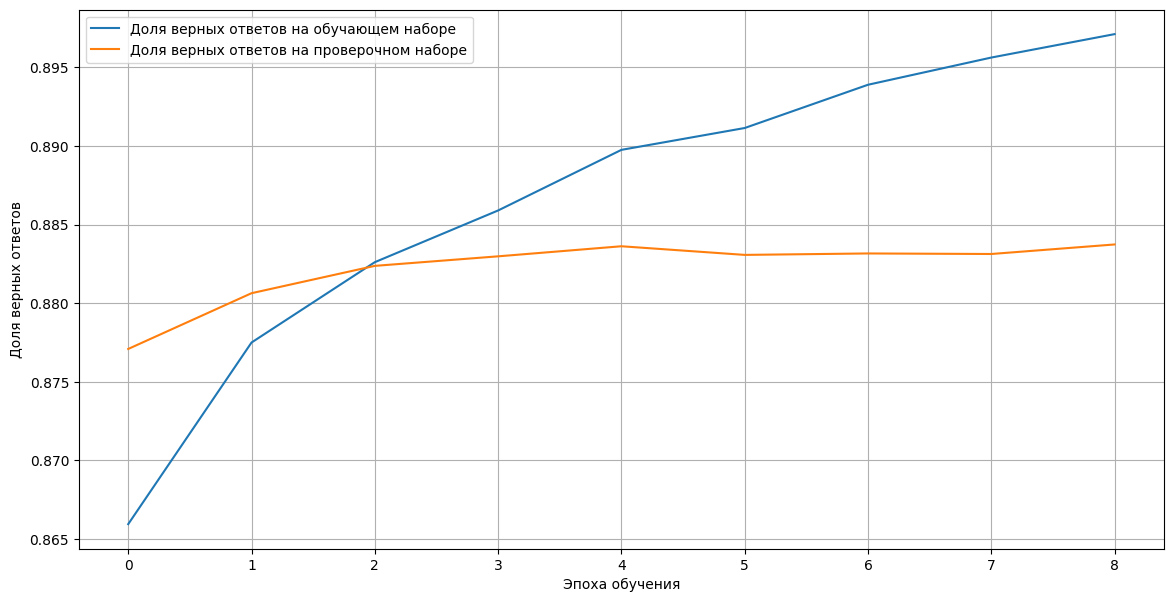

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_4.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_4.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

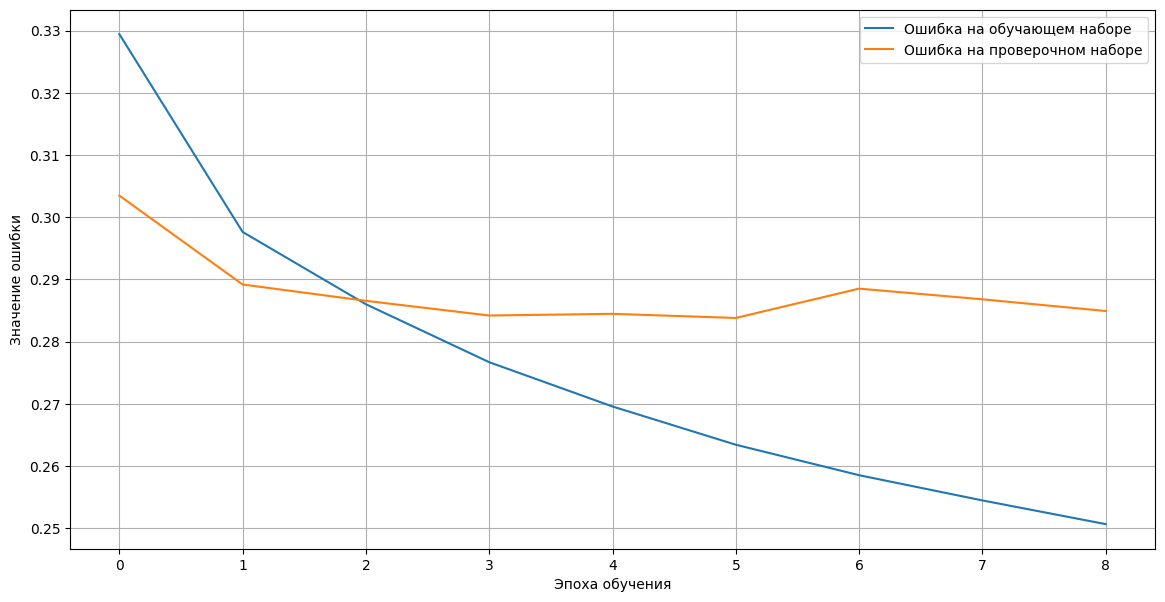

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_4.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_4.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_4.save('model_gender_LSTM_past_verbs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.optimizers import RMSprop

In [ ]:
model_4_enhanced = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),

    Conv1D(256, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.4),

    Reshape((1, -1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(2, activation='softmax')
])

model_4_enhanced.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Настройка параметров Early Stopping
# monitor: метрика для мониторинга
# patience: сколько эпох ждать после последнего лучшего результата
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_4_enhanced = model_4_enhanced.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/35
10931/10931 [==============================] - 168s 15ms/step - loss: 0.3282 - accuracy: 0.8665 - val_loss: 0.3004 - val_accuracy: 0.8736
Epoch 2/35
10931/10931 [==============================] - 102s 9ms/step - loss: 0.2995 - accuracy: 0.8772 - val_loss: 0.2991 - val_accuracy: 0.8815
Epoch 3/35
10931/10931 [==============================] - 102s 9ms/step - loss: 0.2895 - accuracy: 0.8814 - val_loss: 0.2885 - val_accuracy: 0.8807
Epoch 4/35
10931/10931 [==============================] - 98s 9ms/step - loss: 0.2823 - accuracy: 0.8847 - val_loss: 0.2894 - val_accuracy: 0.8807
Epoch 5/35
10931/10931 [==============================] - 101s 9ms/step - loss: 0.2770 - accuracy: 0.8865 - val_loss: 0.2868 - val_accuracy: 0.8821
Epoch 6/35
10931/10931 [==============================] - 101s 9ms/step - loss: 0.2730 - accuracy: 0.8889 - val_loss: 0.2978 - val_accuracy: 0.8822
Epoch 7/35
10931/10931 [==============================] - 99s 9ms/step - loss: 0.2699 - accuracy: 0.8899 - val_l

In [ ]:
val_loss, val_accuracy = model_4_enhanced.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

2733/2733 [==============================] - 11s 4ms/step - loss: 0.2945 - accuracy: 0.8825
Функционал ошибки: 0.29446348547935486 
Точность модели: 0.8825446367263794


## **LogitRegression**

In [ ]:
# Разделение на признаки и целевую переменную
X = data['text_preprocessing_past_verbs']
y = data['sex']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Заменяем все значения NaN пустой строкой
X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test_vec)

# Оценка модели
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71     15116
           1       0.92      0.98      0.95     72330

    accuracy                           0.92     87446
   macro avg       0.90      0.79      0.83     87446
weighted avg       0.92      0.92      0.91     87446



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.9172060471605333


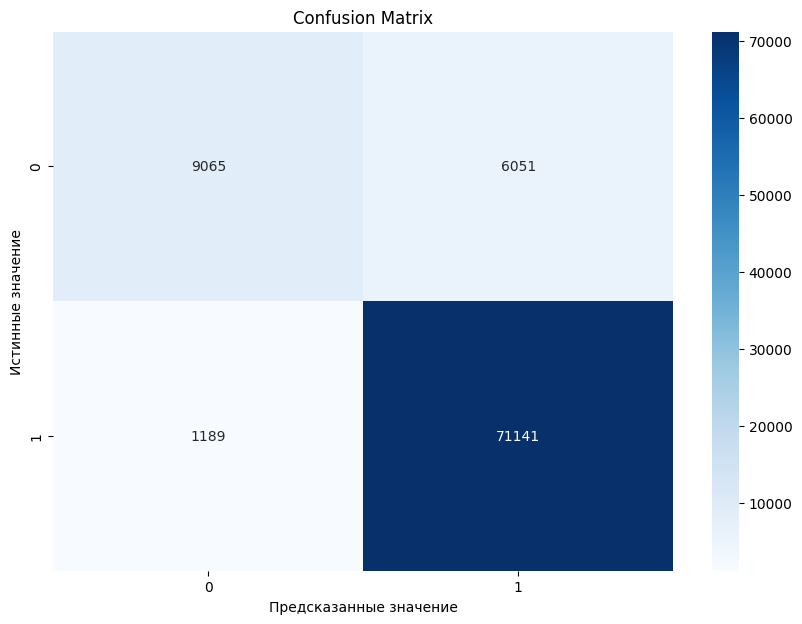

In [ ]:
# Вычисление матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Предсказанные значение')
plt.ylabel('Истинные значение')
plt.title('Confusion Matrix')
plt.show()

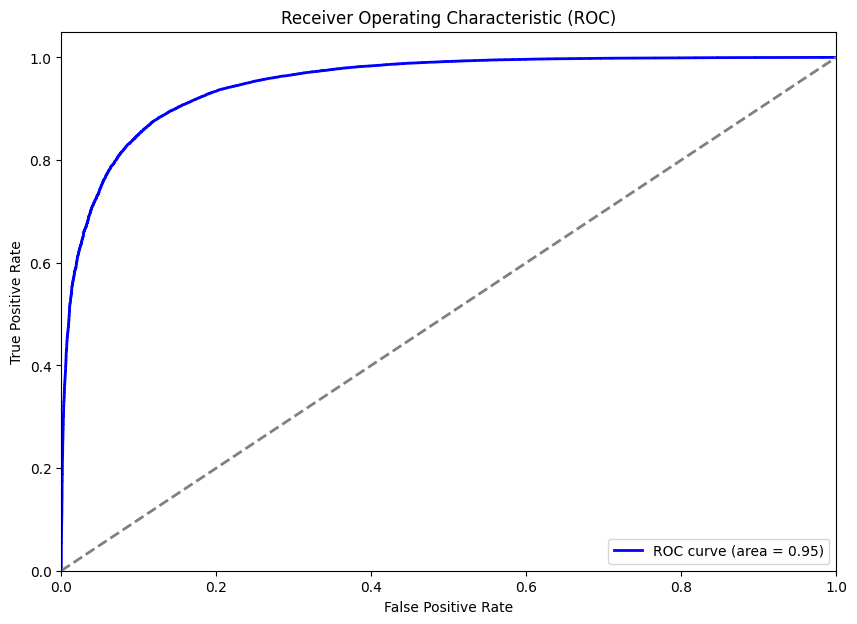

In [ ]:
# Предсказания вероятностей класса для ROC-кривой
y_prob = model.predict_proba(X_test_vec)[:, 1]

# Вычисление метрик для ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob)

# Визуализация ROC-кривой
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Получение важных слов
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()

# Создание DataFrame с результатами
importance_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='coefficient', ascending=False)

# Вывод самых важных слов
print("Слова, которые больше всего повлияли на принятие решений модели:")
print(importance_df.head(20))

Слова, которые больше всего повлияли на принятие решений модели:
             word  coefficient
51925       видел    11.367605
323622    получил    11.197672
469332      ходил     9.436104
406286    смотрел     8.439246
481154      читал     8.412573
239792    написал     7.625875
134241  занимался     7.551208
113843      думал     7.460043
334416      пошел     7.439035
305431      писал     7.242650
156566       ирка     7.234930
192485      купил     7.116154
109832       дора     7.108289
499022       юрка     6.751197
316679     поехал     6.715140
375158      решил     6.668452
66598    встретил     6.519494
244281      начал     6.452659
346935     провел     6.385943
66459       встал     6.367691
